In [1]:
import pprint
import torch
import numpy as np
from torch_geometric.data import Data, DataLoader
from gensim.models import Word2Vec
from torch.nn import Linear
from torch_geometric.loader import NeighborSampler, NeighborLoader
from torch_geometric.utils import dropout_edge
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from itertools import combinations
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import os
import scipy as sp
import warnings
from sklearn.utils import shuffle
from collections import Counter, defaultdict
from datasets import load_dataset
import joblib
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
import networkx as nx
import networkx
import sys, traceback, time
from joblib import Parallel, delayed
import warnings
import nltk
import re, string, math
from spacy.tokens import Doc
import spacy
from spacy.lang.xx import MultiLanguage
from spacy.cli import download
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import itertools
from math import log
from sklearn.metrics import accuracy_score, f1_score
from transformers import logging
from transformers import AutoTokenizer, AutoModel, Trainer, AutoModelForSequenceClassification, TrainingArguments
from transformers import BertForSequenceClassification, RobertaForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import get_scheduler
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import sys
import joblib
import time
import numpy as np
import pandas as pd
import logging
import traceback
import math
from tqdm import tqdm
import torch
import torch.nn as nn
import networkx as nx
import scipy as sp
import scipy.sparse as sp
import copy
from tqdm import tqdm
import torch.nn.functional as F
from torch_geometric.data import DataLoader, Data
from collections import OrderedDict
import warnings
from transformers import logging as transform_loggin
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, TopKPooling, GraphConv, SAGPooling, GENConv, GINConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch.nn import Linear, BatchNorm1d, ModuleList, LayerNorm
from sklearn.feature_extraction.text import TfidfTransformer
import torch
import gc


/home/avaldez/envs/test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:

ROOT_DIR = '/home/avaldez/projects/GraphDeepLearning'
OUTPUT_DIR_PATH = ROOT_DIR + '/output/'

EXTERNAL_DISK_PATH = '/media/discoexterno/andric/data/experiments/'




In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def extract_gnn_embeddings(model, data, data_loader):
    """
    Extracts embeddings from the GNN model for the test documents.
    
    Parameters:
    - model: Trained GNN model
    - data: PyG data object containing node features and labels
    - data_loader: DataLoader for test dataset

    Returns:
    - test_embeddings: List of embeddings at each layer
    - test_node_indices: List of node indices corresponding to test documents
    """
    model.eval()  # Set model to evaluation mode
    test_embeddings = [[] for _ in range(model.num_layers + 2)]  # Store embeddings at each step
    test_node_indices = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(next(model.parameters()).device)  # Move batch to device
            x, edge_index = batch.x, batch.edge_index

            emb, embeddings, _ = model(x, edge_index)  # Forward pass to get embeddings
            test_node_indices.append(batch.node_id.cpu().numpy())  # Store node indices

            for i, emb_layer in enumerate(embeddings):
                test_embeddings[i].append(emb_layer)

    return test_embeddings, test_node_indices


def load_data(file_name, path=OUTPUT_DIR_PATH, format_file='.pkl', compress=False):
    print('Loading data: ', file_name)
    path_file = os.path.join(path, file_name + format_file)
    return joblib.load(path_file)

In [9]:

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, dense_hidden_dim, output_dim, dropout, num_layers, edge_attr=False, gnn_type='GCNConv', heads=1, task='node', directed=False):
        super(GNN, self).__init__()
        self.task = task
        self.heads = heads
        self.gnn_type = gnn_type
        self.edge_attr = edge_attr
        self.directed = directed  # Add directed parameter
        self.conv1 = self.build_conv_model(input_dim, hidden_dim, self.heads)
        self.norm1 = nn.LayerNorm(hidden_dim * heads) # BatchNorm1d, LayerNorm
        self.convs = nn.ModuleList()
        self.lns = nn.ModuleList()
        for l in range(num_layers):
            self.convs.append(self.build_conv_model(hidden_dim * heads, hidden_dim, self.heads))
            self.lns.append(nn.LayerNorm(hidden_dim * heads))

        # Post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim * heads, dense_hidden_dim),
            #nn.Dropout(dropout),
            #nn.LayerNorm(dense_hidden_dim),
            nn.Linear(dense_hidden_dim, int(dense_hidden_dim // 2)),
            #nn.Dropout(dropout),
            #nn.LayerNorm(int(dense_hidden_dim // 2)),
            nn.Linear(int(dense_hidden_dim // 2), output_dim),
        )

        self.dropout = dropout
        self.num_layers = num_layers

    def build_conv_model(self, input_dim, hidden_dim, heads):
        if self.gnn_type == 'GCNConv':
            return GCNConv(input_dim, hidden_dim)
        elif self.gnn_type == 'GATConv':
            return GATConv(input_dim, hidden_dim, heads=heads)
        elif self.gnn_type == 'TransformerConv':
            if self.edge_attr:
                return TransformerConv(input_dim, hidden_dim, heads=heads, edge_dim=1)
            else:    
                return TransformerConv(input_dim, hidden_dim, heads=heads)

    def forward(self, x, edge_index, edge_attr=None, batch=None):
        # Handle undirected graphs by adding reverse edges
        #if not self.directed:
        #    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # Add reverse edges
        #    if self.edge_attr:
        #        edge_attr = torch.cat([edge_attr, edge_attr], dim=0)  # Duplicate edge_attr for reverse edges

        # Pass through the GNN layers
        #print(edge_index.shape, edge_attr.shape)
        if self.edge_attr:
            x = self.conv1(x, edge_index, edge_attr)
        else:
            x = self.conv1(x, edge_index)

        emb = x
        x = F.relu(x)
        x = self.norm1(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        for i in range(self.num_layers):
            if self.edge_attr:
                x = self.convs[i](x, edge_index, edge_attr)
            else:
                x = self.convs[i](x, edge_index)

            emb = x
            x = F.relu(x)
            x = self.lns[i](x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        if self.task == 'graph':
            x = global_mean_pool(x, batch)

        x = self.post_mp(x)
        return emb, None, F.log_softmax(x, dim=1)


In [18]:
import torch

config = {
        'build_graph': False,
        'dataset_name': 'semeval24', # autext23, semeval24, coling24, autext23_s2, semeval24_s2
        'cut_off_dataset': '10-25-25', # train-val-test
        "nfi": 'llm', # llm, w2v, random
        'cuda_num': 1,
        "llm_name": 'microsoft/deberta-v3-base',

}
nfi_dir = config["llm_name"].split("/")[1] # nfi -> llm
file_name_data = f"hetero_data_{config['dataset_name']}_{config['cut_off_dataset']}perc" # perc_128
output_dir = f'{EXTERNAL_DISK_PATH}hetero_graph'

data = load_data(file_name_data, path=f'{output_dir}/{nfi_dir}/', format_file='.pkl', compress=False)
data = data.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move to GPU if available

print(data)

# Define the model (ensure hyperparameters match your saved model)
input_dim = 768 # Number of input features
hidden_dim = 100
dense_hidden_dim = 32
output_dim = 2  # Number of classes
dropout = 0.5
num_layers = 1
gnn_type = 'TransformerConv'  # Adjust based on the saved model
heads = 1  # Used for GATConv or TransformerConv if applicable
task = 'node'
edge_attr = True

# Initialize the model
#(self, input_dim, hidden_dim, dense_hidden_dim, output_dim, dropout, num_layers, edge_attr=False, gnn_type='GCNConv', heads=1, task='node', directed=False):

model = GNN(input_dim, hidden_dim, dense_hidden_dim, output_dim, dropout, num_layers, edge_attr)


# Load the trained model checkpoint
#checkpoint_path = "model_checkpoint.pth"  # Update with actual path
model_path = f"{output_dir}/models/gnn_model_llm_{file_name_data}.pt"
checkpoint = torch.load(model_path)
print("Checkpoint Keys:", checkpoint.keys())

missing_keys, unexpected_keys  = model.load_state_dict(torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")), strict=False)

# Debugging: Print missing or unexpected keys
if missing_keys:
    print(f" Warning: Missing keys in state_dict -> {missing_keys}")
if unexpected_keys:
    print(f" Warning: Unexpected keys in state_dict -> {unexpected_keys}")

model.eval()  # Set to evaluation mode


# Define test loader (ensure batch size and neighbor sampling match your model training)
test_loader = NeighborLoader(
    data,
    num_neighbors=[10, 10],  # Adjust based on your graph connectivity
    batch_size=32,  # Adjust batch size
    input_nodes=data.test_mask,  # Ensure test mask is properly set in your dataset
    shuffle=False,
)

Loading data:  hetero_data_semeval24_10-25-25perc


Data(x=[52216, 768], edge_attr=[16681895, 1], y=[52216], directed_edge_index=[2, 16681895], undirected_edge_index=[2, 27592228], train_mask=[52216], val_mask=[52216], test_mask=[52216], graph_metrics=[52216, 5])
Checkpoint Keys: odict_keys(['conv1.lin_key.weight', 'conv1.lin_key.bias', 'conv1.lin_query.weight', 'conv1.lin_query.bias', 'conv1.lin_value.weight', 'conv1.lin_value.bias', 'conv1.lin_skip.weight', 'conv1.lin_skip.bias', 'norm1.weight', 'norm1.bias', 'convs.0.lin_key.weight', 'convs.0.lin_key.bias', 'convs.0.lin_query.weight', 'convs.0.lin_query.bias', 'convs.0.lin_value.weight', 'convs.0.lin_value.bias', 'convs.0.lin_skip.weight', 'convs.0.lin_skip.bias', 'lns.0.weight', 'lns.0.bias', 'post_mp.0.weight', 'post_mp.0.bias', 'post_mp.1.weight', 'post_mp.1.bias', 'post_mp.2.weight', 'post_mp.2.bias'])


/home/avaldez/envs/test/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:60: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [19]:
# Extract embeddings
test_embeddings, test_node_indices = extract_gnn_embeddings(model, data, test_loader)

# Plot the embeddings at each step (input features, after 1st layer, and after 2nd layer)
steps = ['Input Features', 'After 1st Layer', 'After 2nd Layer']
for i, embeddings in enumerate(test_embeddings):
    # Combine embeddings from all batches
    combined_embeddings = np.vstack(embeddings)
    test_nodes_combined = np.concatenate(test_node_indices)

    # Reduce dimensions using PCA
    reduced_embeddings = PCA(n_components=2).fit_transform(combined_embeddings)
    
    # Plot the reduced embeddings
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                c=data.y[test_nodes_combined].cpu().numpy(), cmap='viridis', alpha=0.7)
    plt.colorbar()
    plt.title(f'{steps[i]} Embeddings of Test Set')

    # Save the figure
    plt.savefig(f'test_emb_{i}.png', dpi=300, bbox_inches="tight")
    plt.show()


ValueError: `MessagePassing.propagate` only supports integer tensors of shape `[2, num_messages]`, `torch_sparse.SparseTensor` or `torch.sparse.Tensor` for argument `edge_index`.

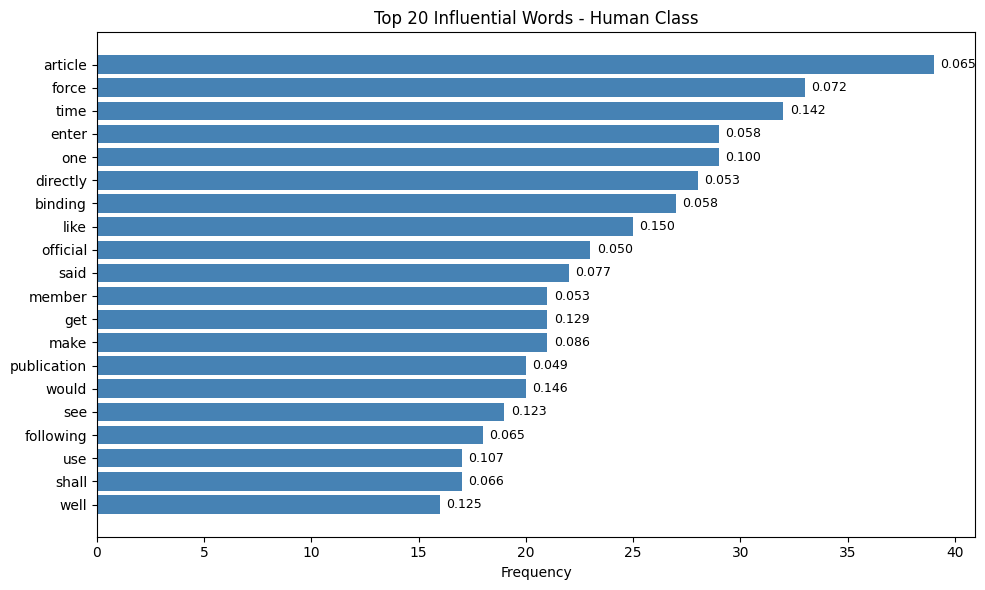

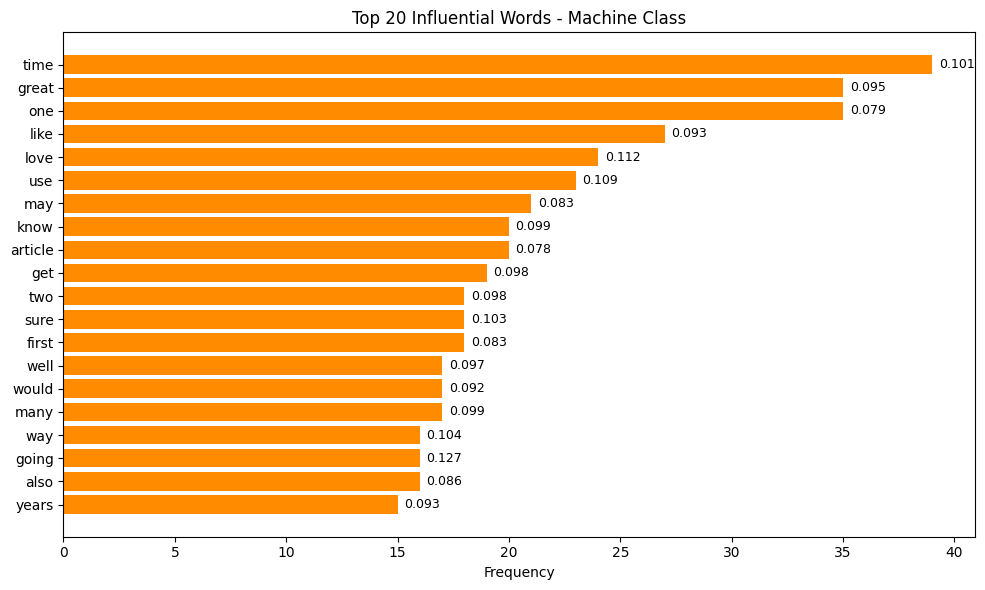

In [3]:
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pandas as pd

# ---------- CONFIG ----------
PATH = '/home/avaldez/projects/GraphDeepLearning/outputs/'
json_path = PATH + "autext23_data.json"  # autext23_data | semeval24_data | coling24_data
top_k = 20
label_names = {0: "Human", 1: "Machine"}
colors = {0: "steelblue", 1: "darkorange"}
# ----------------------------

# Load data
with open(json_path, "r") as f:
    data = json.load(f)

# Collect frequency and attention values
word_freq = defaultdict(Counter)
word_attn = defaultdict(lambda: defaultdict(list))

for entry in data:
    label = entry["label"]
    for word_info in entry["top_words"]:
        word = word_info["word"]
        attn = word_info["attention"]
        word_freq[label][word] += 1
        word_attn[label][word].append(attn)

# Create plot per class
for label in [0, 1]:
    # Build data
    word_data = []
    for word, freq in word_freq[label].items():
        avg_attn = sum(word_attn[label][word]) / len(word_attn[label][word])
        word_data.append((word, freq, avg_attn))
    
    # Sort and take top_k
    word_data = sorted(word_data, key=lambda x: x[1], reverse=True)[:top_k]
    df = pd.DataFrame(word_data, columns=["word", "frequency", "avg_attention"])
    df = df.sort_values("frequency", ascending=True)

    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(df["word"], df["frequency"], color=colors[label])
    plt.xlabel("Frequency")
    plt.title(f"Top {top_k} Influential Words - {label_names[label]} Class")

    for i, (freq, attn) in enumerate(zip(df["frequency"], df["avg_attention"])):
        plt.text(freq + 0.3, i, f"{attn:.3f}", va="center", fontsize=9)

    plt.tight_layout()
    plt.show()


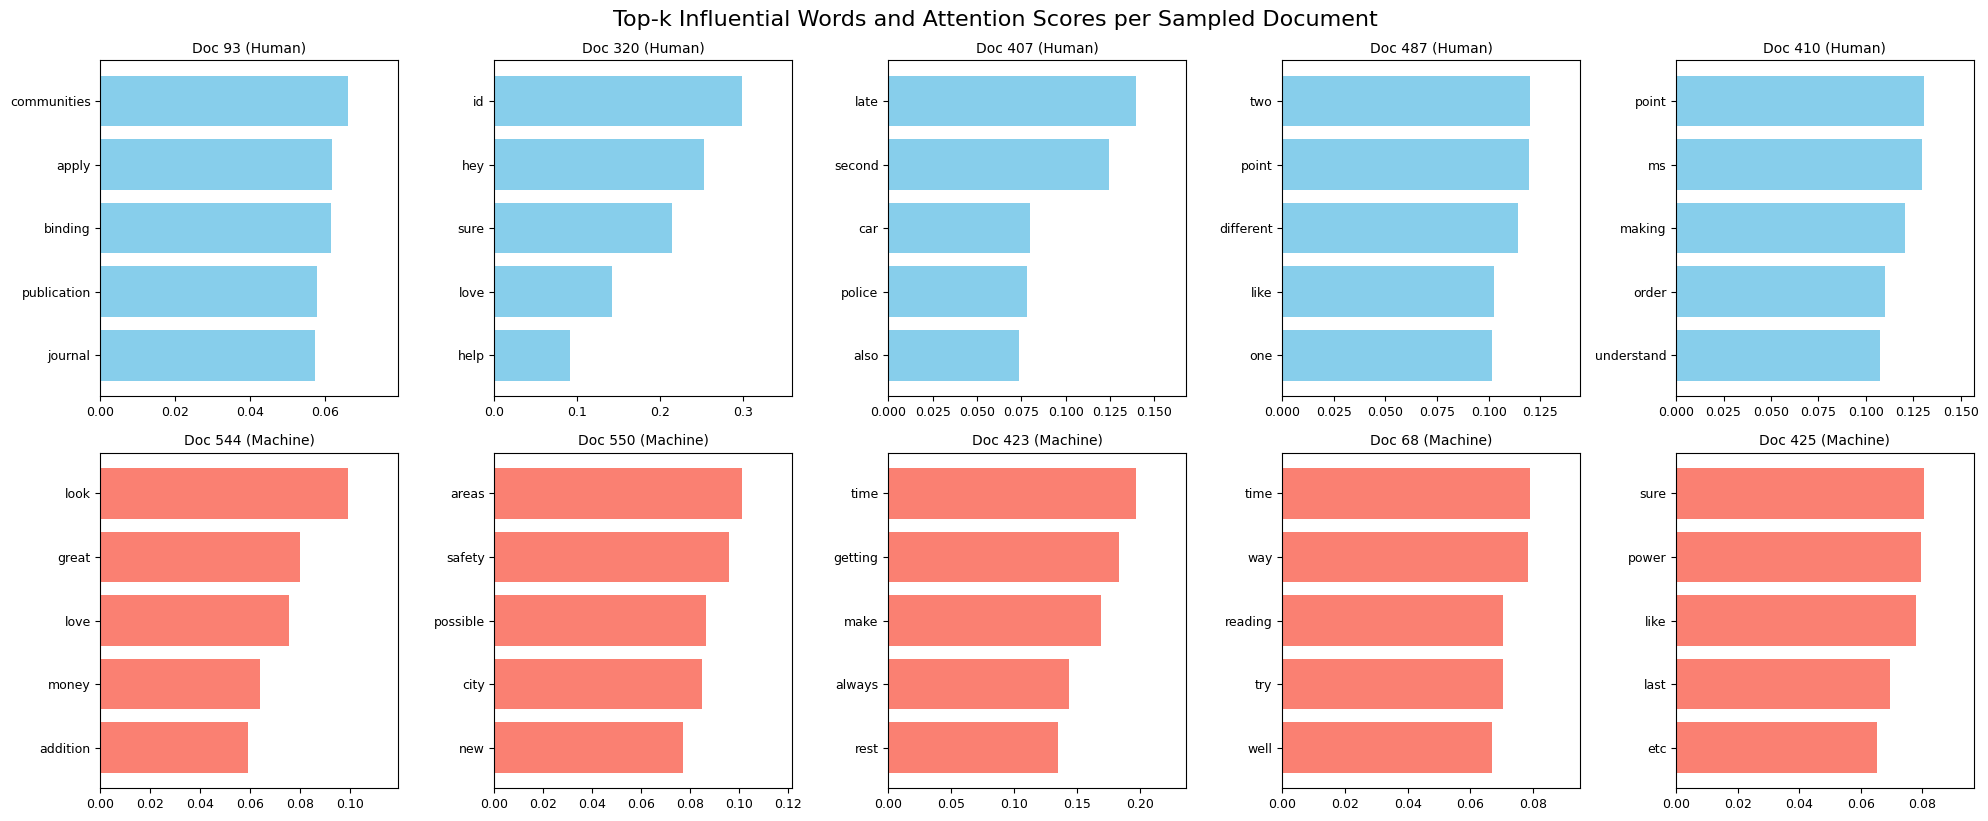

In [5]:
import json
import random
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
#json_path = "coling24_data.json"  # <-- update path
docs_per_class = 5
top_k_words = 5
label_names = {0: "Human", 1: "Machine"}
colors = {0: "skyblue", 1: "salmon"}
# ----------------------------

# Load data
with open(json_path, "r") as f:
    data = json.load(f)

# Group docs by class
docs_by_label = {0: [], 1: []}
for doc in data:
    docs_by_label[doc["label"]].append(doc)

# Sample random documents per class
samples = {
    label: random.sample(docs, min(docs_per_class, len(docs)))
    for label, docs in docs_by_label.items()
}

# Flatten all sampled docs into one list
all_samples = []
for label, docs in samples.items():
    for doc in docs:
        all_samples.append((label, doc))

# Plot settings
n_cols = 5
n_rows = (len(all_samples) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4), squeeze=False)

# Plot each doc's top-k word-attention
for idx, (label, doc) in enumerate(all_samples):
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]

    top_words = sorted(doc["top_words"], key=lambda x: x["attention"], reverse=True)[:top_k_words]
    words = [w["word"] for w in top_words]
    scores = [w["attention"] for w in top_words]

    ax.barh(words[::-1], scores[::-1], color=colors[label])
    ax.set_title(f'Doc {doc["doc_id"]} ({label_names[label]})', fontsize=10)
    ax.set_xlim(0, max(scores)*1.2)
    ax.tick_params(axis='both', labelsize=9)

# Remove empty subplots
for i in range(len(all_samples), n_rows * n_cols):
    row, col = divmod(i, n_cols)
    fig.delaxes(axes[row][col])

plt.tight_layout()
plt.suptitle("Top-k Influential Words and Attention Scores per Sampled Document", fontsize=16, y=1.02)
plt.show()
